# Fitting radial profiles to galaxies

### Isaac Cheng - October 2021

Read Section 4.5 ("CO Radial Profiles") of the VERTICO paper and also look at Table 1. Can
calculate eccentricity of ellipse from position angle + inclination. Also take a look at
[`photutils.aperture.EllipticalAnnulus`](https://photutils.readthedocs.io/en/stable/api/photutils.aperture.EllipticalAnnulus.html)
and [this tutorial](https://photutils.readthedocs.io/en/stable/aperture.html).
Fit annuli starting from the centre, moving outward. The semiminor axis should be at least
the beam width for the VERTICO data. Results should be similar to Figure 9 of the VERTICO
paper.


In [1]:
# May need to do this if running remote server with VS Code
%cd "/arc/home/IsaacCheng/coop_f2021/warmup"
# 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import astropy.units as u
import astropy.coordinates as coord
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
import fits_plot_utils as utils
from photutils.aperture import aperture_photometry, EllipticalAnnulus, EllipticalAperture
import dill
from radio_beam import Beam
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.patches import Ellipse

/arc/home/IsaacCheng/coop_f2021/warmup


# Functions


In [4]:
def calc_eccentricity(inclination):
    """
    Calculates the eccentricities of galaxies given their inclinations. Assumes galaxies
    are perfectly circular disks (reasonable for spiral galaxies, not necessarily true for
    other morphologies).
    
    The inclination of a galaxy, i, is defined as the ratio of its observed (semi-)minor
    axis, b, to its observed (semi-)major axis, a:
                                    cos(i) := b/a
    Thus, the eccentricity, e, of a galaxy can be directly calculated from its
    inclination:
                        e := sqrt(1 - (b/a)^2) = sqrt(1 - cos^2(i))
    
    Parameters:
      inclination :: float or array-like
        The inclinations of the galaxies in degrees
    
    Returns: eccentricity
      eccentricity :: float or array-like
        The eccentricities of the galaxies
    """
    cosi = np.cos(np.deg2rad(inclination))
    return np.sqrt(1 - cosi * cosi)


# def get_annulus_quantities(data, annulus, avg_func=np.nanmedian):
#     """
#     Parameters:
#       annulus :: `photutils.aperture.EllipticalAnnulus` object
#     Returns: radius, average
#     """


def calc_tot_sn_annulus(signal, annulus, noise=None, include_bad=True, phot_kwargs=None):
    """
    Calculates total signal (and optionally noise) of data enclosed in an annulus. Only
    works with one annulus per function call (because of aperture_photometry() keywords).
    
    TODO: finish docstring
    
    Parameters:
      include_bad :: bool (optional)
        If True, includes NaNs and infs in signal & noise arrays by setting these values
        to zero. If False, exclude NaNs and infs entirely from calculation.
    
    Returns: tot_signal, tot_noise
      tot_signal :: float
        The total signal of the data in the annulus. This is a straight arithmetic sum.
      tot_noise :: float or None
        If noise is not None, this is the total noise of the data in the annulus. Unlike
        the total signal, the total noise is summed in quadrature. If noise is None, this
        return value is also None.
    """
    if noise is not None:
        mask = (~np.isfinite(signal)) | (~np.isfinite(noise))
    else:
        mask = ~np.isfinite(signal)
    if include_bad:
        # Set non-detections and bad pixels to zero
        signal = np.ma.masked_array(signal, mask=mask).filled(fill_value=0.0)
        if noise is not None:
            noise = np.ma.masked_array(noise, mask=mask).filled(fill_value=0.0)
        aper_mask = None  # include all pixels
    else:
        # Skip non-detections and bad pixels from summation
        aper_mask = mask
    # 
    # Method 1
    # 
    # ann_mask = annulus.to_mask(method="exact")
    # tot_signal = ann_mask.multiply(signal)
    # tot_signal = np.nansum(tot_signal)
    # if noise is not None:
    #     # Add noise in quadrature
    #     tot_noise = ann_mask.multiply(noise * noise)
    #     tot_noise = np.nansum(tot_noise)
    #     tot_noise = np.sqrt(tot_noise)
    # else:
    #     tot_noise = None
    # return tot_signal, tot_noise
    # 
    # Method 2
    # 
    if phot_kwargs is None:
        phot_results = aperture_photometry(signal, annulus, error=noise, mask=aper_mask)
    else:
        phot_results = aperture_photometry(
            signal, annulus, error=noise, mask=aper_mask, **phot_kwargs
        )
    if noise is not None:
        return (
            float(phot_results["aperture_sum"].value),
            float(phot_results["aperture_sum_err"].value),
        )
    else:
        return (float(phot_results["aperture_sum"].value), None)


def calc_avg_sn_annulus(
    signal, annulus, noise=None, include_bad=True, method="exact", func="median"
):
    """
    ! NEED TO DEBUG !
    ! ANNULI ARE NOT BEING MASKED PROPERLY !
    Calculates average signal (and optionally noise) of data enclosed in an annulus. Only
    works with one annulus per function call.
    
    TODO: finish docstring
    
    Parameters:
      include_bad :: bool (optional)
        If True, includes NaNs and infs in signal & noise arrays by setting these values
        to zero. If False, exclude NaNs and infs entirely from calculation.
    
    Returns: tot_signal, tot_noise
      avg_signal :: float
        The average (either arithmetic mean or median) signal of the data in the annulus
      avg_noise :: float or None
        If noise is not None, this is the average noise of the data in the annulus. If
        func=="mean", the noise is summed in quadrature and divided by the area of the
        annulus to get the average noise. If func=="median", the average noise is the
        median noise.
        If noise is None, this return value is also None.
    """
    if include_bad:
        fill_value = 0
        # if noise is not None:
        #     mask = (~np.isfinite(signal)) | (~np.isfinite(noise))
        # else:
        #     mask = ~np.isfinite(signal)
        # # Set non-detections and bad pixels to zero
        # signal = np.ma.masked_array(signal, mask=mask).filled(fill_value=fill_value)
        # if noise is not None:
        #     noise = np.ma.masked_array(noise, mask=mask).filled(fill_value=fill_value)
    else:
        fill_value = np.nan
    if noise is not None:
        mask = (~np.isfinite(signal)) | (~np.isfinite(noise))
    else:
        mask = ~np.isfinite(signal)
    # Set non-detections and bad pixels to zero
    # signal = np.copy(signal)
    signal = np.ma.masked_array(signal, mask=mask).filled(fill_value=fill_value)
    if noise is not None:
        # noise = np.copy(noise)
        noise = np.ma.masked_array(noise, mask=mask).filled(fill_value=fill_value)
    # 
    ann_mask = annulus.to_mask(method=method)
    ann_mask = ann_mask.to_image(signal.shape)
    ann_mask = np.ma.masked_where(ann_mask == 0, ann_mask).filled(fill_value=np.nan)
    fig, ax = plt.subplots()
    img = ax.imshow(ann_mask, origin="lower")
    fig.colorbar(img)
    plt.show()
    # 
    avg_signal = signal * ann_mask
    fig, ax = plt.subplots()
    img = ax.imshow(avg_signal, origin="lower")
    fig.colorbar(img)
    plt.show()
    # 
    if func == "median":
        func = np.nanmedian
        avg_signal = func(avg_signal)
        if noise is not None:
            avg_noise = noise * ann_mask
            avg_noise = func(noise)
    elif func == "mean":
        func = np.nansum
        # Straight arithmetic sum divided by area
        avg_signal = func(avg_signal)
        avg_signal = avg_signal / annulus.area
        if noise is not None:
            # Add noise in quadrature then divide by area
            avg_noise = noise * noise * ann_mask
            avg_noise = func(avg_noise)
            avg_noise = np.sqrt(avg_noise) / annulus.area
    else:
        raise ValueError("func must be 'median' or 'mean'")
    if noise is None:
        avg_noise = None
    return avg_signal, avg_noise


# def calc_avg_sn_annulus(
#     signal, annulus, noise=None, include_bad=True, method="exact", func="median"
# ):
#     """
#     Calculates average signal (and optionally noise) of data enclosed in an annulus. Only
#     works with one annulus per function call.
    
#     TODO: finish docstring
    
#     Parameters:
#       include_bad :: bool (optional)
#         If True, includes NaNs and infs in signal & noise arrays by setting these values
#         to zero. If False, exclude NaNs and infs entirely from calculation.
    
#     Returns: tot_signal, tot_noise
#       avg_signal :: float
#         The average (either arithmetic mean or median) signal of the data in the annulus
#       avg_noise :: float or None
#         If noise is not None, this is the average noise of the data in the annulus. If
#         func=="mean", the noise is summed in quadrature and divided by the area of the
#         annulus to get the average noise. If func=="median", the average noise is the
#         median noise.
#         If noise is None, this return value is also None.
#     """
#     if include_bad:
#         fill_value = 0
#         # if noise is not None:
#         #     mask = (~np.isfinite(signal)) | (~np.isfinite(noise))
#         # else:
#         #     mask = ~np.isfinite(signal)
#         # # Set non-detections and bad pixels to zero
#         # signal = np.ma.masked_array(signal, mask=mask).filled(fill_value=fill_value)
#         # if noise is not None:
#         #     noise = np.ma.masked_array(noise, mask=mask).filled(fill_value=fill_value)
#     else:
#         fill_value = np.nan
#     if noise is not None:
#         mask = (~np.isfinite(signal)) | (~np.isfinite(noise))
#     else:
#         mask = ~np.isfinite(signal)
#     # Set non-detections and bad pixels to zero
#     signal = np.ma.masked_array(signal, mask=mask).filled(fill_value=fill_value)
#     if noise is not None:
#         noise = np.ma.masked_array(noise, mask=mask).filled(fill_value=fill_value)
#     # 
#     ann_mask = annulus.to_mask(method=method)
#     fig, ax = plt.subplots()
#     img = ax.imshow(ann_mask.to_image(signal.shape), origin="lower")
#     fig.colorbar(img)
#     plt.show()
#     fig, ax = plt.subplots()
#     img = ax.imshow(ann_mask.multiply(np.ones_like(signal), fill_value=fill_value), origin="lower")
#     fig.colorbar(img)
#     plt.show()
#     # 
#     avg_signal = ann_mask.multiply(signal, fill_value=fill_value)
#     fig, ax = plt.subplots()
#     img = ax.imshow(avg_signal, origin="lower")
#     fig.colorbar(img)
#     plt.show()
#     # 
#     if func == "median":
#         func = np.nanmedian
#         avg_signal = func(avg_signal)
#         if noise is not None:
#             avg_noise = ann_mask.multiply(noise, fill_value=fill_value)
#             avg_noise = func(noise)
#     elif func == "mean":
#         func = np.nansum
#         # Straight arithmetic sum divided by area
#         avg_signal = func(avg_signal)
#         avg_signal = avg_signal / annulus.area
#         if noise is not None:
#             # Add noise in quadrature then divide by area
#             avg_noise = ann_mask.multiply(noise * noise, fill_value=fill_value)
#             avg_noise = func(avg_noise)
#             avg_noise = np.sqrt(avg_noise) / annulus.area
#     else:
#         raise ValueError("func must be 'median' or 'mean'")
#     if noise is None:
#         avg_noise = None
#     return avg_signal, avg_noise
    

def fit_annuli(
    center,
    i,
    pa,
    min_width,
    min_width_ax="minor",
    n_annuli=None,
    data=None,
    noise=None,
    snr_cutoff=None,
    wcs=None,
):
    """
    Work in progress. Only have n_annuli implemented so far
    """
    if isinstance(center, coord.SkyCoord):
        if wcs is None:
            raise ValueError("wcs must be provided if center is not in pixel coordinates")
        center = wcs.world_to_pixel(center)
    e = calc_eccentricity(i)  # eccentricity of galaxy
    pa = np.deg2rad((pa + 90) % 360.0)  # PA starts at North and increases Eastward (CCW)
    annuli, a_ins, a_outs, b_ins, b_outs = [], [], [], [], []
    b_to_a_factor = 1 / np.sqrt(1 - e * e)
    if n_annuli is not None:
        if n_annuli < 1 or not isinstance(n_annuli, int):
            raise ValueError("n_annulus must be an integer > 0")
        for i in range(n_annuli):
            # Assume min_width_ax == "minor"
            b_in = i * min_width
            a_in = b_in * b_to_a_factor
            if min_width_ax == "major":
                b_in, a_in = a_in, b_in
            elif min_width_ax != "minor":
                raise ValueError("min_width_ax must be either 'major' or 'minor'")
            b_out = b_in + min_width
            a_out = b_out * b_to_a_factor
            a_ins.append(a_in)
            a_outs.append(a_out)
            b_ins.append(b_in)
            b_outs.append(b_out)
            # print(i, a_in, a_out, b_in, b_out)
            if a_in == 0 and b_in == 0:
                annulus = EllipticalAperture(center, a_out, b_out, theta=pa)
            else:
                annulus = EllipticalAnnulus(
                    center, a_in=a_in, b_in=b_in, a_out=a_out, b_out=b_out, theta=pa
                )
            annuli.append(annulus)
        annuli, a_ins, a_outs, b_ins, b_outs = np.asarray(
            (annuli, a_ins, a_outs, b_ins, b_outs)
        )
        return annuli, a_ins, a_outs, b_ins, b_outs
    else:
        raise ValueError("n_annuli must be provided. Sorry. This is a WIP")


def get_beam_size(header):
    """
    Assumes pixel is square.

    TODO: finish docstring
    """
    beam = Beam.from_fits_header(header)
    # Assume square pixels
    deg_per_px = proj_plane_pixel_scales(WCS(header).celestial)[0] * u.deg
    #
    beam_major = (beam.major.to(u.deg) / deg_per_px).to(u.dimensionless_unscaled).value
    beam_minor = (beam.minor.to(u.deg) / deg_per_px).to(u.dimensionless_unscaled).value
    beam_pa = (beam.pa + 90.0 * u.deg).to(u.deg).value  # PA starts at N and increases CCW
    return beam_major, beam_minor, beam_pa


def calc_radius(a_in, a_out, b_in, b_out):
    """
    The radius of an annulus is defined as the arithmetic mean of the annulus' midpoints
    along the semimajor & semiminor axes
    """
    a_mid = (a_in + a_out) / 2
    b_mid = (b_in + b_out) / 2
    return (a_mid + b_mid) / 2


def radio_radial_profile(
    data,
    header,
    center,
    pa,
    i,
    noise=None,
    n_annuli=1,
    wcs=None,
    include_bad=True,
    method="exact",
    func="median",
    phot_kwargs=None,
):
    beam_major, beam_minor, beam_pa = get_beam_size(header)
    min_width = np.max((beam_major, beam_minor))
    annuli, a_ins, a_outs, b_ins, b_outs = fit_annuli(
        center, i, pa, min_width, n_annuli=n_annuli, wcs=wcs
    )
    print(annuli)
    radii = calc_radius(a_ins, a_outs, b_ins, b_outs)
    # tot_data, tot_noise = [], []
    # for annulus in annuli:
    #     annulus_data, annulus_noise = calc_tot_sn_annulus(
    #         data, annulus, noise, include_bad=include_bad, phot_kwargs=phot_kwargs
    #     )
    #     tot_data.append(annulus_data)
    #     tot_noise.append(annulus_noise)
    # tot_data, tot_noise = np.asarray(tot_data), np.asarray(tot_noise)
    # return tot_data, tot_noise, radii, annuli, a_ins, a_outs, b_ins, b_outs
    avg_data, avg_noise = [], []
    for annulus in annuli:
        annulus_data, annulus_noise = calc_avg_sn_annulus(
            data, annulus, noise, include_bad=include_bad, method=method, func=func,
        )
        avg_data.append(annulus_data)
        avg_noise.append(annulus_noise)
    avg_data, avg_noise = np.asarray(avg_data), np.asarray(avg_noise)
    return avg_data, avg_noise, radii, annuli, a_ins, a_outs, b_ins, b_outs


# Radial profiles of VERTICO data


In [3]:
# 
co_type = "9as"  # "nyquist" or "9as"
co_unit = "Kkms-1"  # "Msolpc" or "Kkms-1"
# 
# Load CO map data
#
if co_type == "9as":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_{co_unit}.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_{co_unit}.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
if co_unit == "Msolpc-2":
    # Convert uncertainty from K.km/s to M_sun/pc^2
    alpha_co = 4.35  # M_sun/pc^2 per K.km/s
    R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
    # Apply Eq. (7) of Brown et al. (2021)
    unc_co_noDistErr = alpha_co / R_21 * unc_co
elif co_unit == "Kkms-1":
    unc_co_noDistErr = unc_co
else:
    raise ValueError("co_unit must be 'Msolpc-2' or 'Kkms-1'")
print("USING", co_type, co_unit, "CO DATA")
# print(wcs_co.pixel_to_world(data_co.shape[0]//2, data_co.shape[1]//2))  # approx center
# print(header_co)
# 
# Quantities from Table 1 of Brown et al. (2021)
# 
vcc792_pa = 158  # position angle (deg)
vcc792_i = 61  # inclination (deg)
# vcc792_centre = coord.SkyCoord("12 25 22.16 +10 01 00.12", unit=(u.hourangle, u.deg), frame=header_co["RADESYS"].lower())
vcc792_centre = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
vcc792_dist = 16.5 * u.Mpc  # distance to centre of Virgo cluster

Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (80, 80)   float64   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (80, 80)   float64   
USING 9as Kkms-1 CO DATA


[<EllipticalAperture([40.04544802, 39.81000143], a=9.281994028619193, b=4.50000000014364, theta=4.328416544945937)>
 <EllipticalAnnulus([40.04544802, 39.81000143], a_in=9.281994028619193, a_out=18.563988057238387, b_in=4.50000000014364, b_out=9.00000000028728, theta=4.328416544945937)>
 <EllipticalAnnulus([40.04544802, 39.81000143], a_in=18.563988057238387, a_out=27.845982085857578, b_in=9.00000000028728, b_out=13.50000000043092, theta=4.328416544945937)>
 <EllipticalAnnulus([40.04544802, 39.81000143], a_in=27.845982085857578, a_out=37.12797611447677, b_in=13.50000000043092, b_out=18.00000000057456, theta=4.328416544945937)>
 <EllipticalAnnulus([40.04544802, 39.81000143], a_in=37.12797611447677, a_out=46.40997014309596, b_in=18.00000000057456, b_out=22.5000000007182, theta=4.328416544945937)>]


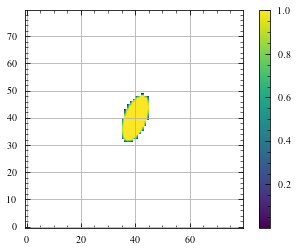

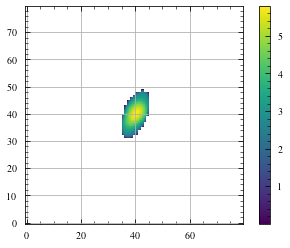

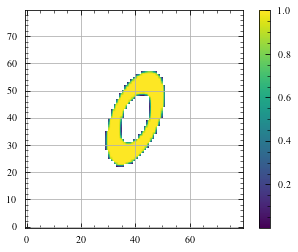

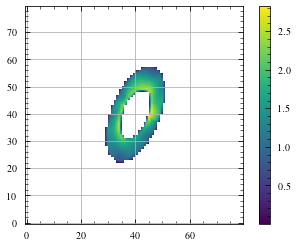

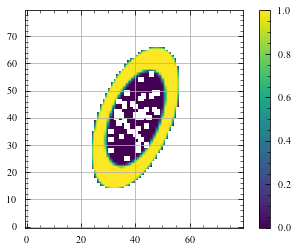

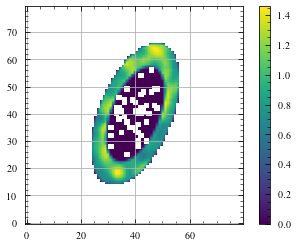

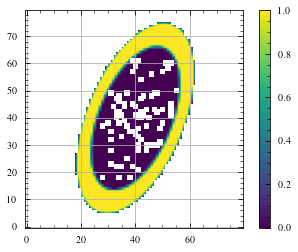

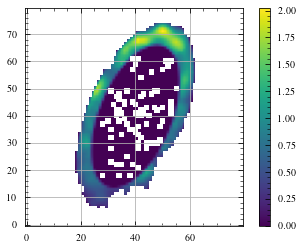

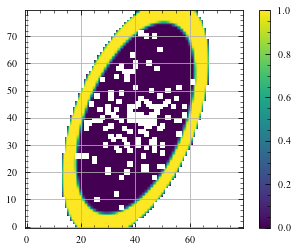

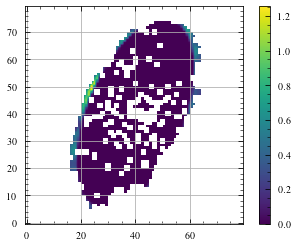

In [5]:
# (
#     vcc792_sum_data,
#     vcc792_sum_noise,
#     vcc792_radii,
#     vcc792_annuli,
#     vcc792_a_ins,
#     vcc792_a_outs,
#     vcc792_b_ins,
#     vcc792_b_outs,
# ) = radio_radial_profile(
#     data_co,
#     header_co,
#     vcc792_centre,
#     vcc792_pa,
#     vcc792_i,
#     noise=unc_co_noDistErr,
#     # noise=None,
#     n_annuli=5,
#     wcs=wcs_co,
# )
(
    vcc792_avg_data,
    vcc792_avg_noise,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = radio_radial_profile(
    data_co,
    header_co,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    noise=unc_co_noDistErr,
    # noise=None,
    n_annuli=5,
    wcs=wcs_co,
    include_bad=False,
    func="median",
)

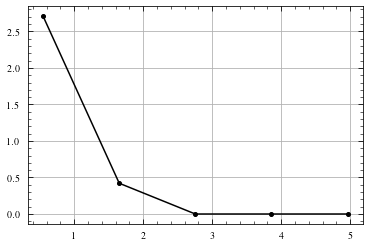

In [13]:
pc_per_px = utils.calc_pixel_size(WCS(header_co), dist=vcc792_dist)[0]
# annuli_area = (
#     np.array([annulus.area for annulus in vcc792_annuli])
#     # * pc_per_px[0].value / 1000
#     # * pc_per_px[1].value / 1000
# )
# avg_co = vcc792_sum_data / annuli_area
# avg_co_err = vcc792_sum_noise / annuli_area
# print(avg_co)
# print(avg_co_err)
#
fig, ax = plt.subplots()
ebar = ax.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=vcc792_avg_data,
    # yerr=avg_co_err / (avg_co * np.log(10)),
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
# ax.semilogy()
# ebar[-1][0].set_linestyle("--")


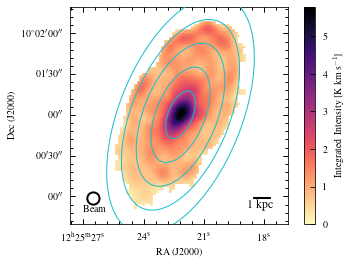

In [129]:
fig, ax = plt.subplots(subplot_kw={"projection": wcs_co})
data_co_masked = np.ma.masked_where(data_co <= 0, data_co).filled(np.nan)
# img = ax.contourf(data_co_masked, cmap="magma_r", levels=22)
img = ax.imshow(data_co_masked, cmap="magma_r", vmin=0)
cbar = fig.colorbar(img)
cbar.ax.minorticks_off()
cbar.set_label(r"Integrated Intensity [$\rm K\; km\; s^{-1}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=1, zorder=2
    )
    ax.add_patch(ellipse)
# Add beam size
co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
xbeam, ybeam = 8, 9
ellipse = Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    angle=(co_beam_pa - 90) % 360.0,
    ls="-", edgecolor="k", fc='None', lw=2, zorder=2
)
ax.add_patch(ellipse)
xtxt, ytxt = (xbeam - 4, ybeam - 5)
ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, wcs_co, vcc792_dist, scalebar_factor=1, label="1 kpc")
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()

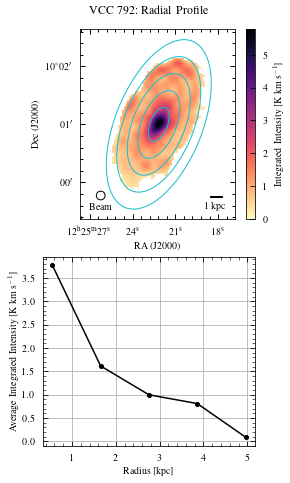

In [184]:
%matplotlib inline
plt.close("all")
# 
fig = plt.figure(figsize=mpl.figure.figaspect(1.7))
ax = fig.add_subplot(2, 1, 1, projection=wcs_co)
data_co_masked = np.ma.masked_where(data_co <= 0, data_co).filled(np.nan)
# img = ax.contourf(data_co_masked, cmap="magma_r", levels=22)
img = ax.imshow(data_co_masked, cmap="magma_r", vmin=0)
cbar = fig.colorbar(img, fraction=0.045)
cbar.ax.minorticks_off()
cbar.set_label(r"Integrated Intensity [$\rm K\; km\; s^{-1}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=1, zorder=2
    )
    ax.add_patch(ellipse)
ax.set_ylim(-9, data_co.shape[0] + 9)
# Add beam size
co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
# xbeam, ybeam = 10, 11
xbeam, ybeam = 10, 3
ellipse = Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
    angle=(co_beam_pa - 90) % 360.0,
    ls="-", edgecolor="k", fc='None', lw=1, zorder=2
)
ax.add_patch(ellipse)
# xtxt, ytxt = (xbeam - 5.5, ybeam - 7)
xtxt, ytxt = (xbeam - 6, ybeam - 7)
ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, wcs_co, vcc792_dist, scalebar_factor=1, label="1 kpc",
                   fontsize=10, pad=0.75, sep=4)
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# 
ax2 = fig.add_subplot(2, 1, 2)
pc_per_px = utils.calc_pixel_size(WCS(header_co), dist=vcc792_dist)[0]
annuli_area = (
    np.array([annulus.area for annulus in vcc792_annuli])
    # * pc_per_px[0] / 1000
    # * pc_per_px[1] / 1000
)
avg_co = vcc792_sum_data / annuli_area
avg_co_err = vcc792_sum_noise / annuli_area
#
ebar = ax2.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=avg_co,
    yerr=avg_co_err / (avg_co * np.log(10)),
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar[-1][0].set_linestyle("--")
# ax2.semilogy()
# ax2.set_ylim(bottom=1)
# ax2.grid(False)
ax2.set_xlabel("Radius [kpc]")
# ax2.set_ylabel(r"Average Integrated Intensity [$\rm K\; km\; s^{-1}\; kpc^{-2}$]")
ax2.set_ylabel(r"Average Integrated Intensity [$\rm K\; km\; s^{-1}$]")
# 
fig.suptitle("VCC 792: Radial Profile")
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)
# fig.savefig("imgs/vcc792_rad_prof_Kkms_v2.pdf")
plt.show()

# Radial profiles of NGVS data


## 9 arcsec beam, 2 arcsec pixel NGVS binned data


In [3]:
MLi_data_path = "/arc/home/IsaacCheng/coop_f2021/binned_data/vcc792_MLi_BINNED_reproject_interp+masked_star2_9as.txt"
MLi_data = pd.read_csv(MLi_data_path, sep=" ")
MLi_coords = MLi_data["id"].values.reshape(80, 80)  # correct. No transpose needed
MLi_density = MLi_data["M_density"].values.reshape(80, 80)
MLi_density_err = MLi_data["M_density_err"].values.reshape(80, 80)
# 
co_type = "9as"  # "nyquist" or "9as"
co_unit = "Kkms-1"  # "Msolpc" or "Kkms-1"
# 
# Load CO map data
#
if co_type == "9as":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_{co_unit}.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_{co_unit}.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
if co_unit == "Msolpc-2":
    # Convert uncertainty from K.km/s to M_sun/pc^2
    alpha_co = 4.35  # M_sun/pc^2 per K.km/s
    R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
    # Apply Eq. (7) of Brown et al. (2021)
    unc_co_noDistErr = alpha_co / R_21 * unc_co
elif co_unit == "Kkms-1":
    unc_co_noDistErr = unc_co
else:
    raise ValueError("co_unit must be 'Msolpc-2' or 'Kkms-1'")
print("USING", co_type, co_unit, "CO DATA")
# print(wcs_co.pixel_to_world(data_co.shape[0]//2, data_co.shape[1]//2))  # approx center
# print(header_co)
# 
# Quantities from Table 1 of Brown et al. (2021)
# 
vcc792_pa = 158  # position angle (deg)
vcc792_i = 61  # inclination (deg)
# vcc792_centre = coord.SkyCoord("12 25 22.16 +10 01 00.12", unit=(u.hourangle, u.deg), frame=header_co["RADESYS"].lower())
vcc792_centre = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
vcc792_dist = 16.5 * u.Mpc  # distance to centre of Virgo cluster

Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (80, 80)   float64   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (80, 80)   float64   
USING 9as Kkms-1 CO DATA


In [7]:
MLi_density_masked = np.ma.masked_where(data_co <= 0, MLi_density).filled(np.nan)
MLi_density_err_masked = np.ma.masked_where(data_co <= 0, MLi_density_err).filled(np.nan)
(
    vcc792_sum_data,
    vcc792_sum_noise,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = radio_radial_profile(
    MLi_density_masked,
    header_co,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    noise=MLi_density_err_masked,
    # noise=None,
    n_annuli=5,
    wcs=wcs_co,
)

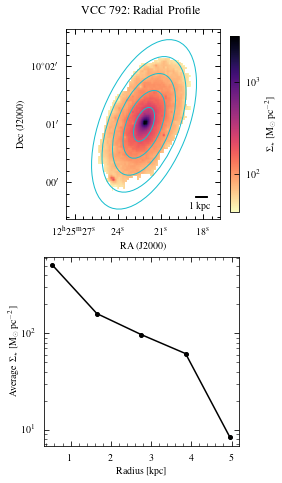

In [9]:
%matplotlib inline
plt.close("all")
# 
fig = plt.figure(figsize=mpl.figure.figaspect(1.7))
ax = fig.add_subplot(2, 1, 1, projection=wcs_co)
MLi_density_masked = np.ma.masked_where(data_co <= 0, MLi_density).filled(np.nan)
# MLi_density_masked = MLi_density
# img = ax.contourf(MLi_density_masked, cmap="magma_r", locator=mpl.ticker.LogLocator(),)
# img = ax.contourf(MLi_density_masked, cmap="magma_r", norm=mpl.colors.LogNorm(),
#                   levels=np.linspace(np.nanmin(MLi_density_masked), np.nanmax(MLi_density_masked), 10))
img = ax.imshow(MLi_density_masked, cmap="magma_r", norm=mpl.colors.LogNorm())
cbar = fig.colorbar(img, fraction=0.045)
cbar.ax.minorticks_off()
cbar.set_label(r"$\Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=1, zorder=2
    )
    ax.add_patch(ellipse)
ax.set_ylim(-9, data_co.shape[0] + 9)
# # Add beam size
# co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
# # xbeam, ybeam = 10, 11
# xbeam, ybeam = 10, 3
# ellipse = Ellipse(
#     xy=(xbeam, ybeam),
#     width=co_beam_minor,
#     height=co_beam_major,
#     # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
#     angle=(co_beam_pa - 90) % 360.0,
#     ls="-", edgecolor="k", fc='None', lw=1, zorder=2
# )
# ax.add_patch(ellipse)
# # xtxt, ytxt = (xbeam - 5.5, ybeam - 7)
# xtxt, ytxt = (xbeam - 6, ybeam - 7)
# ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, wcs_co, vcc792_dist, scalebar_factor=1, label="1 kpc",
                   fontsize=10, pad=0.75, sep=4)
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# 
ax2 = fig.add_subplot(2, 1, 2)
pc_per_px = utils.calc_pixel_size(WCS(header_co), dist=vcc792_dist)[0]
annuli_area = (
    np.array([annulus.area for annulus in vcc792_annuli])
    # * pc_per_px[0] / 1000
    # * pc_per_px[1] / 1000
)
avg_MLi_density = vcc792_sum_data / annuli_area
avg_MLi_density_err = vcc792_sum_noise / annuli_area
#
ebar = ax2.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=avg_MLi_density,
    yerr=avg_MLi_density_err / (avg_MLi_density * np.log(10)),
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar[-1][0].set_linestyle("--")
ax2.semilogy()
# ax2.set_ylim(bottom=1)
ax2.grid(False)
ax2.set_xlabel("Radius [kpc]")
# ax2.set_ylabel(r"Average Integrated Intensity [$\rm K\; km\; s^{-1}\; kpc^{-2}$]")
ax2.set_ylabel(r"Average $\Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]")
# 
fig.suptitle("VCC 792: Radial Profile")
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)
fig.savefig("imgs/vcc792_rad_prof_MLi_yesMask.pdf")
plt.show()

## Voronoi binned NGVS data


In [11]:
# 
# Load NGVS data
# 
# Signal
zband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.3136_8588_6905_10184.fits"
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# # Noise (sigma maps)
# znoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.sig.3136_8588_6905_10184.fits"
# inoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits"
# gnoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_6905_10184.fits"
# unoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.sig.3136_8588_6905_10184.fits"
# # Mask (flap maps)
# zgood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.flag.3136_8588_6905_10184.fits"
# igood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.flag.3136_8588_6905_10184.fits"
# ggood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.flag.3136_8588_6905_10184.fits"
# ugood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.flag.3136_8588_6905_10184.fits"
# Signal
data_z, header_z = utils.load_img(zband_path)
data_i, header_i = utils.load_img(iband_path)
data_g, header_g = utils.load_img(gband_path)
data_u, header_u = utils.load_img(uband_path)
# # Noise
# noise_z, header_noise_z = utils.load_img(znoise_path)
# noise_i, header_noise_i = utils.load_img(inoise_path)
# noise_g, header_noise_g = utils.load_img(gnoise_path)
# noise_u, header_noise_u = utils.load_img(unoise_path)
# # Masks
# good_z, header_good_z = utils.load_img(zgood_path, idx=1)
# good_i, header_good_i = utils.load_img(igood_path, idx=1)
# good_g, header_good_g = utils.load_img(ggood_path, idx=1)
# good_u, header_good_u = utils.load_img(ugood_path, idx=1)
# 
# Load CO map data
#
co_type = "9as"  # "nyquist" or "9as"
co_unit = "Kkms-1"  # "Msolpc" or "Kkms-1"
# 
if co_type == "9as":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_{co_unit}.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_{co_unit}.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
if co_unit == "Msolpc-2":
    # Convert uncertainty from K.km/s to M_sun/pc^2
    alpha_co = 4.35  # M_sun/pc^2 per K.km/s
    R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
    # Apply Eq. (7) of Brown et al. (2021)
    unc_co_noDistErr = alpha_co / R_21 * unc_co
elif co_unit == "Kkms-1":
    unc_co_noDistErr = unc_co
else:
    raise ValueError("co_unit must be 'Msolpc-2' or 'Kkms-1'")
print("USING", co_type, co_unit, "CO DATA")
# 
# Quantities from Table 1 of Brown et al. (2021)
# 
vcc792_pa = 158  # position angle (deg)
vcc792_i = 61  # inclination (deg)
vcc792_centre = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
vcc792_dist = 16.5 * u.Mpc  # distance to centre of Virgo cluster

ngvs_min_width_arcsec = np.max(
    (header_z["IQMAX"], header_i["IQMAX"], header_g["IQMAX"], header_u["IQMAX"])
)
print("Worst NGVS image quality (arcsec):", ngvs_min_width_arcsec)
# 
# Load stellar mass data
# 
MLi_data_path = "/arc/home/IsaacCheng/coop_f2021/binned_data/vcc792_MLi_allVorBinned_snr30.pkl"
with open(MLi_data_path, "rb") as f:
    MLi_data = dill.load(f)
MLi_density = MLi_data["M_density"]
MLi_density_err = MLi_data["M_density_err_noDistErr"]

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co

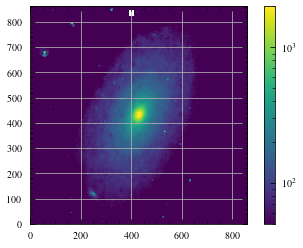

In [15]:
fig, ax = plt.subplots()
img = ax.imshow(MLi_density, origin="lower", norm=mpl.colors.LogNorm(vmin=50, vmax=2000))
cbar = fig.colorbar(img, ax=ax)
plt.show()